
# Results for experiments over KDDCup dataset

In [1]:
%matplotlib inline
from IPython.display import display

import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [2]:
import colors

In [3]:
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')
seaborn.set_context("paper", font_scale=2)

In [4]:
seaborn.__version__

'0.9.0'

In [5]:
METRICS_COLS = ['AUC', 'RMSE', 'Accuracy', 'R2']

In [6]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [7]:
ANCHOR_COURSES = [1, 6, 11, 16, 21, 26, 31]

In [8]:
def read_predictions(filename):
    with open(filename, 'rb') as prediction_file:
        return pickle.load(prediction_file)

def read_file_metrics(true, predicted):
    """Returns a DataFrame with values AUC, RMSE, APS, Accuracy, R2 Score"""
    results = []
    ignored_sequences = 0
    try:
        results.append([metrics.roc_auc_score(true, predicted)])
    except ValueError:
        ignored_sequences += 1
        results.append([numpy.nan])
    results[-1].append(metrics.mean_squared_error(true, predicted)**0.5)
    results[-1].append(metrics.accuracy_score(true, numpy.where(predicted > 0.5, 1, 0)))
    results[-1].append(metrics.r2_score(true, predicted))
    results[-1].append(metrics.recall_score(true, numpy.round(predicted), labels=[0, 1], average=None)[1])
    results[-1].append(true.shape[0])
    if ignored_sequences > 0:    
        print('{} sequences with only one class, ignoring.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=METRICS_COLS + ['PositiveRecall', 'Support'])

In [9]:
def read_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        trues, predictions = [], []
        for filename in get_runs(dirname):
            true, predicted = read_predictions(os.path.join(dirname, filename))
            file_metrics = read_file_metrics(true, predicted)
            file_metrics['Experiment'] = dirname[-16:]
            file_metrics['Pretrained'] = 'pretrained' in dirname
            file_metrics['Run'] = re.search('.*run(\d+).*', filename).group(1)
            course = re.search('.*_c(\d+)_.*', filename)
            if course is not None:
                file_metrics['Course'] = int(re.search('.*_c(\d+)_.*', filename).group(1))
            else:
                file_metrics['Course'] = 1
            metrics_dfs.append(file_metrics)
            trues.append(true)
            predictions.append(predicted)
        general_metrics = read_file_metrics(numpy.concatenate(trues), numpy.concatenate(predictions))
        general_metrics['Experiment'] = dirname[-16:]
        general_metrics['Run'] = -1
        general_metrics['Course'] = -1
        metrics_dfs.append(general_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True).set_index(['Experiment', 'Run', 'Course'])

In [10]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                train, validation = pickle.load(performance_file)
            train = pandas.DataFrame(train, columns=['epoch', 'mse'], dtype=numpy.float32)
            validation = pandas.DataFrame(validation, columns=['epoch', 'mse'], dtype=numpy.float32)
            train['Dataset'] = 'train'
            validation['Dataset'] = 'validation'
            concat = pandas.concat([train, validation])
            concat['Run'] = re.search('.*run(\d+).*', filename).group(1)
            course = re.search('.*_c(\d+)_.*', filename)
            if course is not None:
                concat['Course'] = int(re.search('.*_c(\d+)_.*', filename).group(1))
            else:
                concat['Course'] = 1
            concat['rmse'] = concat['mse']**0.5
            dataframes.append(concat)
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(train_performances):
    performances = []
    for dirname, performance_dataframe in train_performances.items():
        perf = performance_dataframe.groupby(['epoch', 'Run', 'Course']).agg({'rmse': 'std'}).groupby(
            'Course').agg('mean')
        perf['Experiment'] = dirname[-16:]
        performances.append(perf.reset_index())
    performances = pandas.concat(performances, ignore_index=True)
    seaborn.factorplot(x='Course', y='rmse', col="Experiment", data=performances, col_wrap=4)

def graphic_learning_curves(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        performance_dataframe['epoch'] = performance_dataframe.epoch.astype(numpy.int)
        grid = seaborn.FacetGrid(data=performance_dataframe.loc[performance_dataframe['Run'] == '0'],
                                 col='Course', despine=True, ylim=[0, 0.5], aspect=1,
                                 palette='colorblind')
        mapped = grid.map(seaborn.pointplot, 'epoch', 'rmse', 'Dataset').add_legend().set_xticklabels([])
        plt.show()

### Real distribution of labels

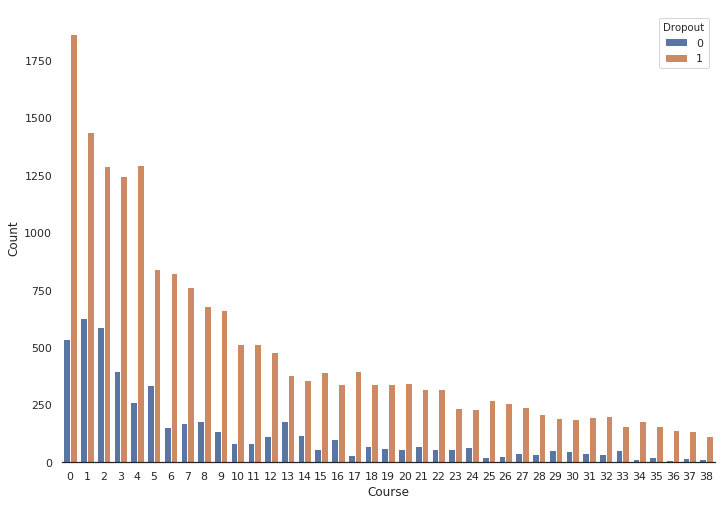

In [11]:
label_dfs = []
dirname = '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-22-18-06/predictions_c{}_run0.p'
for course in range(0, 39):
    true, _ = read_predictions(dirname.format(course))
    for label in [0, 1]:
        label_dfs.append({'Course': course, 'Dropout': label, 'Count': true[true == label].shape[0]})
label_dfs = pandas.DataFrame(label_dfs)
seaborn.set(style='white', rc={'figure.figsize':(11.7,8.27)})
seaborn.barplot(x='Course', y='Count', hue='Dropout', data=label_dfs)
seaborn.despine(left=True)

In [12]:
label_dfs.groupby('Dropout').agg('sum')

,Count,Course
Dropout,,
0,5052,741
1,19072,741


In [13]:
dropout_proportions = label_dfs.groupby(['Course', 'Dropout']).agg('sum')
dropout_proportions['Proportion'] = numpy.nan
for course in dropout_proportions.reset_index().Course:
    dropout_count = dropout_proportions.loc[course, 0].Count
    nodropout_count = dropout_proportions.loc[course, 1].Count
    dropout_proportions.loc[(course, 1),['Proportion']] = dropout_count / (dropout_count + nodropout_count)
    dropout_proportions.loc[(course, 0),['Proportion']] = nodropout_count / (dropout_count + nodropout_count)
dropout_proportions

Count  Proportion
Course Dropout                   
0      0          536    0.776760
       1         1865    0.223240
1      0          628    0.695884
       1         1437    0.304116
2      0          588    0.686734
       1         1289    0.313266
3      0          396    0.759271
       1         1249    0.240729
4      0          261    0.832154
       1         1294    0.167846
5      0          338    0.713073
       1          840    0.286927
6      0          155    0.841837
       1          825    0.158163
7      0          173    0.815368
       1          764    0.184632
8      0          182    0.788863
       1          680    0.211137
9      0          137    0.829177
       1          665    0.170823
10     0           84    0.860233
       1          517    0.139767
11     0           82    0.863105
       1          517    0.136895
12     0          116    0.805695
       1          481    0.194305
13     0          181    0.676786
       1          379    0.323214
14     0          120    0.749478
       1          359    0.250522
...               ...         ...
24     0           65    0.780405
       1          231    0.219595
25     0           22    0.925424
       1          273    0.074576
26     0           28    0.902098
       1          258    0.097902
27     0           39    0.861210
       1          242    0.138790
28     0           38    0.846774
       1          210    0.153226
29     0           53    0.785425
       1          194    0.214575
30     0           48    0.798319
       1          190    0.201681
31     0           39    0.836134
       1          199    0.163866
32     0           35    0.852321
       1          202    0.147679
33     0           52    0.750000
       1          156    0.250000
34     0           16    0.917949
       1          179    0.082051
35     0           24    0.866667
       1          156    0.133333
36     0           12    0.922078
       1          142    0.077922
37     0           18    0.882353
       1          135    0.117647
38     0           16    0.875969
       1          113    0.124031

[78 rows x 2 columns]

## Experiments with LSTM model

In [14]:
LSTM_EXPERIMENTS_DIRS = [
#     '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-09-35/',
#     '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-19-47/',
#     '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-29/',
#     '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-38/',
#     '/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-04-12-39/', # Truncated
    # Not filtered
    '/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-17-13-47/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-27-15-06/',  # Full eval
    '/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-27-21-28',  # Full eval
]

## Learning curves

In [14]:
lstm_performances = read_performances(LSTM_EXPERIMENTS_DIRS)

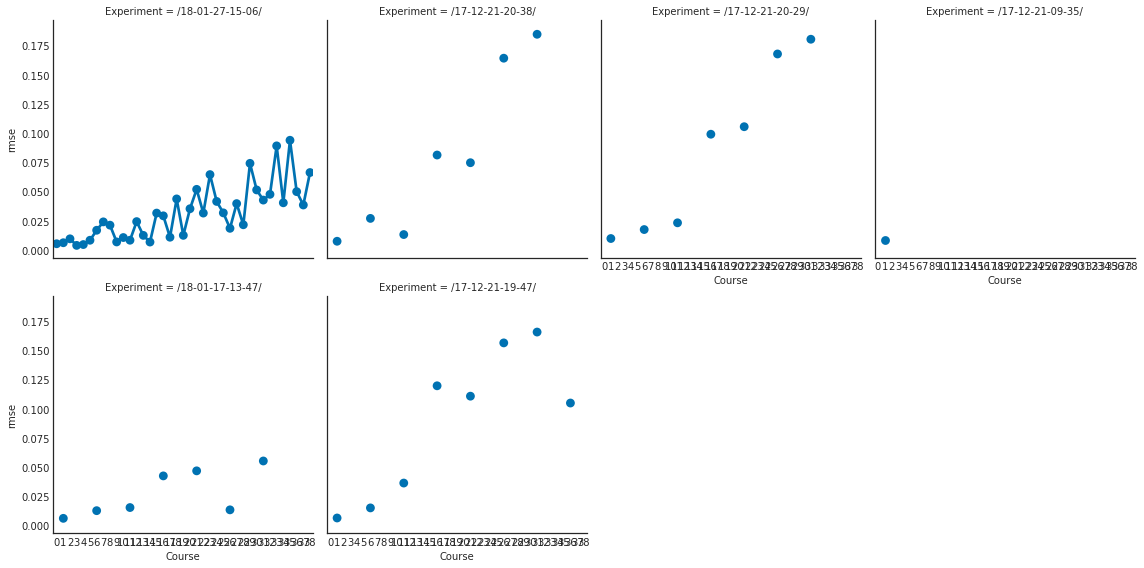

In [43]:
graphic_performances(lstm_performances)

In [24]:
for dirname, dataframe in lstm_performances.items():
    print(dirname)
    idx = dataframe.groupby(['Dataset', 'Course'])['epoch'].transform(max) == dataframe['epoch']
    display(dataframe[idx].groupby(['Course', 'Dataset']).agg('mean'))

/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-27-15-06/


epoch       mse      rmse
Course Dataset                              
0      train       450.0  0.119462  0.345595
       validation  450.0  0.128060  0.357674
1      train       450.0  0.113074  0.336265
       validation  450.0  0.121499  0.348567
2      train       450.0  0.118586  0.344361
       validation  450.0  0.124399  0.352500
3      train       450.0  0.122326  0.349751
       validation  450.0  0.120412  0.346965
4      train       450.0  0.081093  0.284768
       validation  450.0  0.077276  0.277980
5      train       450.0  0.112596  0.335553
       validation  450.0  0.122098  0.349398
6      train       450.0  0.081952  0.286272
       validation  450.0  0.071622  0.267609
7      train       450.0  0.088907  0.298170
       validation  450.0  0.122646  0.350202
8      train       450.0  0.118424  0.344123
       validation  450.0  0.151541  0.389237
9      train       450.0  0.086310  0.293782
       validation  450.0  0.098741  0.314067
10     train       450.0  0.080312  0.283358
       validation  450.0  0.098407  0.313143
11     train       450.0  0.068847  0.262350
       validation  450.0  0.080947  0.284425
12     train       450.0  0.071768  0.267787
       validation  450.0  0.104877  0.323478
13     train       450.0  0.069439  0.263461
       validation  450.0  0.061955  0.248892
14     train       450.0  0.094219  0.306951
       validation  450.0  0.099408  0.315082
...                  ...       ...       ...
24     train       450.0  0.053727  0.231786
       validation  450.0  0.120180  0.346500
25     train       450.0  0.046149  0.214772
       validation  450.0  0.054848  0.230864
26     train       450.0  0.050772  0.225322
       validation  450.0  0.070493  0.264665
27     train       450.0  0.067654  0.259783
       validation  450.0  0.110952  0.332668
28     train       450.0  0.063607  0.252148
       validation  450.0  0.111187  0.333445
29     train       450.0  0.031903  0.178435
       validation  450.0  0.133839  0.365737
30     train       450.0  0.056895  0.238398
       validation  450.0  0.138990  0.372396
31     train       450.0  0.055984  0.236608
       validation  450.0  0.141390  0.374552
32     train       450.0  0.028505  0.168819
       validation  450.0  0.092695  0.304300
33     train       450.0  0.028274  0.168038
       validation  450.0  0.173280  0.414947
34     train       450.0  0.021181  0.145237
       validation  450.0  0.051134  0.221602
35     train       450.0  0.025018  0.158068
       validation  450.0  0.117733  0.341859
36     train       450.0  0.027688  0.165291
       validation  450.0  0.074438  0.271719
37     train       450.0  0.026849  0.163755
       validation  450.0  0.079402  0.280404
38     train       450.0  0.024321  0.153139
       validation  450.0  0.071194  0.260462

[78 rows x 3 columns]

## Performance Metrics

In [15]:
lstm_metrics = read_metrics(LSTM_EXPERIMENTS_DIRS)
lstm_metrics

AUC  Accuracy  PositiveRecall Pretrained  \
Experiment       Run Course                                                  
/18-01-17-13-47/ 1    31     0.787785  0.836134        0.879397      False   
                 0    6      0.843785  0.892857        0.943030      False   
                 1    6      0.839726  0.897959        0.964848      False   
                 0    31     0.852596  0.819328        0.859296      False   
                      21     0.654544  0.762274        0.871069      False   
                      16     0.744433  0.800905        0.944282      False   
                 1    16     0.738306  0.791855        0.906158      False   
                      21     0.669264  0.780362        0.883648      False   
                      1      0.867906  0.854237        0.947112      False   
                 0    1      0.875055  0.855206        0.939457      False   
                 1    26     0.927949  0.916084        0.972868      False   
                      11     0.809030  0.881469        0.967118      False   
                 0    11     0.821508  0.886477        0.970986      False   
                      26     0.799211  0.909091        1.000000      False   
                 -1  -1      0.837232  0.856614        0.941078        NaN   
/18-01-27-15-06/ 1    33     0.713942  0.778846        0.897436      False   
                      28     0.598747  0.846774        0.957143      False   
                 0    3      0.785377  0.830395        0.959167      False   
                      10     0.799358  0.870216        0.974855      False   
                 1    25     0.743923  0.918644        0.978022      False   
                      1      0.873245  0.848910        0.913013      False   
                      12     0.842928  0.892797        0.956341      False   
                 0    27     0.747245  0.879004        0.933884      False   
                      31     0.889963  0.848739        0.864322      False   
                 1    31     0.873083  0.861345        0.904523      False   
                      27     0.637688  0.893238        0.983471      False   
                 0    1      0.868024  0.853753        0.948504      False   
                      12     0.851154  0.864322        0.918919      False   
                      25     0.784882  0.925424        0.981685      False   
                 1    3      0.779875  0.815805        0.907126      False   
...                               ...       ...             ...        ...   
s/18-01-27-21-28 1    22     0.713359  0.829787        0.931034      False   
                 0    22     0.644008  0.864362        0.981191      False   
                 1    8      0.777271  0.822506        0.945588      False   
                      17     0.665487  0.935035        0.989950      False   
                      5      0.870131  0.854839        0.909524      False   
                 0    34     0.604399  0.912821        0.966480      False   
                      7      0.790746  0.877268        0.980366      False   
                 1    36     0.768779  0.928571        0.978873      False   
                 0    18     0.703540  0.851582        0.964602      False   
                 1    20     0.657971  0.872818        0.959420      False   
                 0    15     0.703913  0.876652        0.967005      False   
                 1    3      0.779148  0.822492        0.945556      False   
                 0    29     0.741393  0.817814        0.912371      False   
                      32     0.880622  0.911392        0.945545      False   
                      24     0.752348  0.868243        0.939394      False   
                 1    11     0.798203  0.881469        0.980658      False   
                      26     0.859565  0.909091        0.953488      False   
                 0    13     0.930903  0.930357        0.965699      False   
                      1      0.875116  0.840194        0

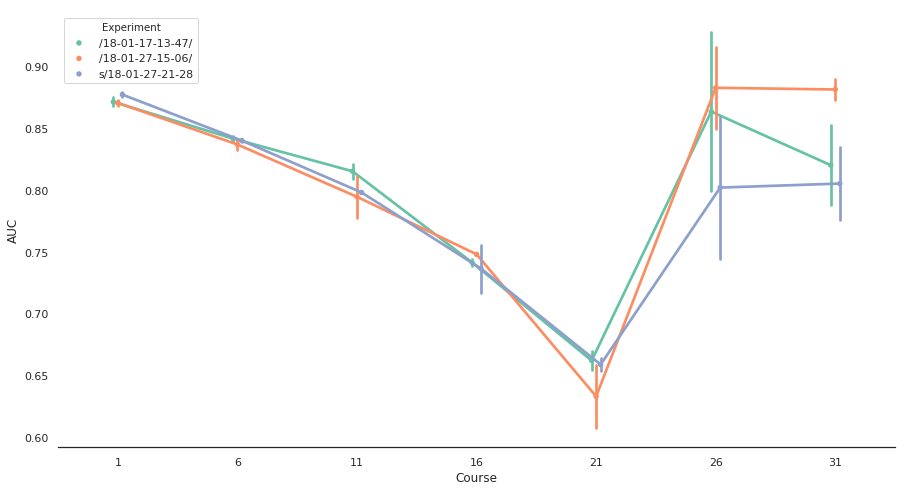

In [16]:
plt.subplots(figsize=(15,8))
exploring_lstm_metrics = lstm_metrics.reset_index()
exploring_lstm_metrics = exploring_lstm_metrics[exploring_lstm_metrics.Course.isin(ANCHOR_COURSES)]
seaborn.pointplot(data=exploring_lstm_metrics, x='Course', y='AUC', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

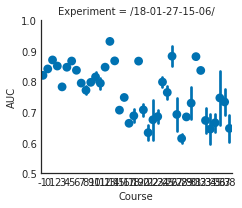

In [27]:
grid = seaborn.FacetGrid(data=lstm_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0.5, 1])
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

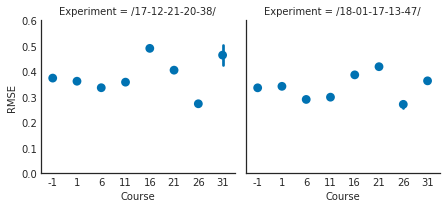

In [48]:
grid = seaborn.FacetGrid(data=lstm_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0, 0.6])
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

## Experiments with Embedded LSTM model

In [19]:
EMBEDDING_EXPERIMENTS_DIRS = [
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-51/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-59/',
#      '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-02/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-59/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-11-05/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-19-28/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-21-04/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-03-17-53/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-03-10-28/',
# #     '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-09-20-33/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-09-20-49/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-10-14-15/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-10-14-58/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-11-14-38/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-12-18-40/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-12-19-06/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-13-21-15/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-28-01-23/',  # Full eval filtered
    # Not filtered
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-17-14-01/',
    '/home/mteruel/edm/results/kddcup/embedding/aied_results/pretrained/predictions/18-01-17-14-46/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-22-21-50/', # Full eval
    '/home/mteruel/edm/results/kddcup/embedding/aied_results/pretrained/predictions/18-01-27-22-16/',  # Full eval
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-28-23-57/', # Full eval
    # After AIED
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-02-15-17-49/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-02-16-14-13/',  # LR unknown
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-02-23-15-09/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-02-23-15-34/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-03-04-02-02/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-03-04-02-17/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/19-06-06-08-25',  # Full eval
]

## Learning curves

In [23]:
embedding_performances = read_performances(EMBEDDING_EXPERIMENTS_DIRS)

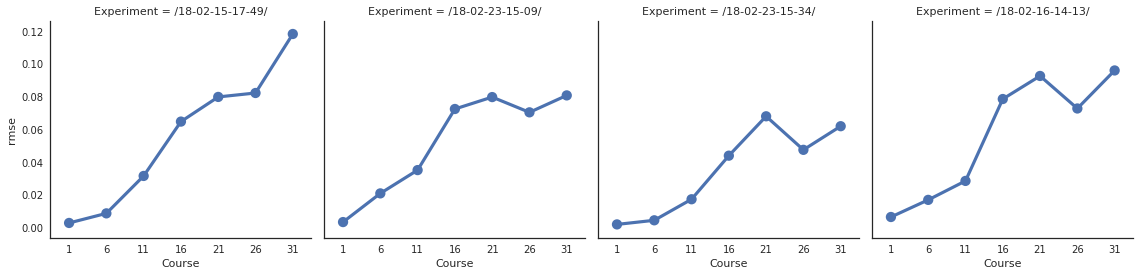

In [13]:
graphic_performances(embedding_performances)

## Performance Metrics

In [22]:
embedding_metrics = read_metrics(EMBEDDING_EXPERIMENTS_DIRS)

In [28]:
embedding_metrics.groupby(['Experiment', 'Course']).aggregate('mean')[METRICS_COLS][-40:]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
s/19-06-06-08-25 -1      0.831207  0.329043  0.863476  0.346049
                  0      0.848636  0.335004  0.849854  0.352790
                  1      0.886029  0.334005  0.853027  0.472853
                  2      0.860234  0.348604  0.850027  0.435102
                  3      0.782910  0.361435  0.823708  0.285284
                  4      0.848499  0.288252  0.900000  0.405011
                  5      0.872802  0.343352  0.842105  0.423776
                  6      0.847574  0.287054  0.900000  0.381134
                  7      0.804613  0.315444  0.880470  0.339009
                  8      0.768673  0.363786  0.821346  0.205338
                  9      0.809774  0.335352  0.845387  0.205988
                  10     0.825838  0.290527  0.894343  0.297977
                  11     0.806164  0.295868  0.886477  0.258847
                  12     0.855474  0.307864  0.892797  0.394452
                  13     0.927696  0.252843  0.927679  0.707393
                  14     0.873967  0.330233  0.855950  0.419175
                  15     0.701142  0.320740  0.876652  0.102956
                  16     0.764960  0.391933  0.807692  0.127267
                  17     0.693125  0.242651  0.931555  0.166661
                  18     0.739143  0.348290  0.850365  0.159791
                  19     0.868240  0.268222  0.922886  0.455544
                  20     0.724689  0.330993  0.869077  0.087868
                  21     0.709484  0.381484  0.822997  0.006535
                  22     0.776220  0.331126  0.867021  0.147462
                  23     0.759472  0.353226  0.850168  0.216172
                  24     0.778988  0.356684  0.849662  0.256835
                  25     0.803114  0.259203  0.920339  0.025338
                  26     0.793882  0.270963  0.910839  0.167323
                  27     0.750636  0.330265  0.873665  0.086300
                  28     0.653383  0.346905  0.856855  0.072325
                  29     0.728847  0.389863  0.827935  0.098129
                  30     0.732237  0.391553  0.806723  0.047774
                  31     0.842546  0.355489  0.842437  0.074257
                  32     0.910679  0.229508  0.938819  0.581359
                  33     0.700012  0.421711  0.790865  0.051510
                  34     0.653457  0.282683  0.912821 -0.060975
                  35     0.660524  0.335703  0.863889  0.024737
                  36     0.655810  0.238522  0.938312  0.205793
                  37     0.644033  0.386092  0.826797 -0.439585
                  38     0.589049  0.362823  0.852713 -0.212125

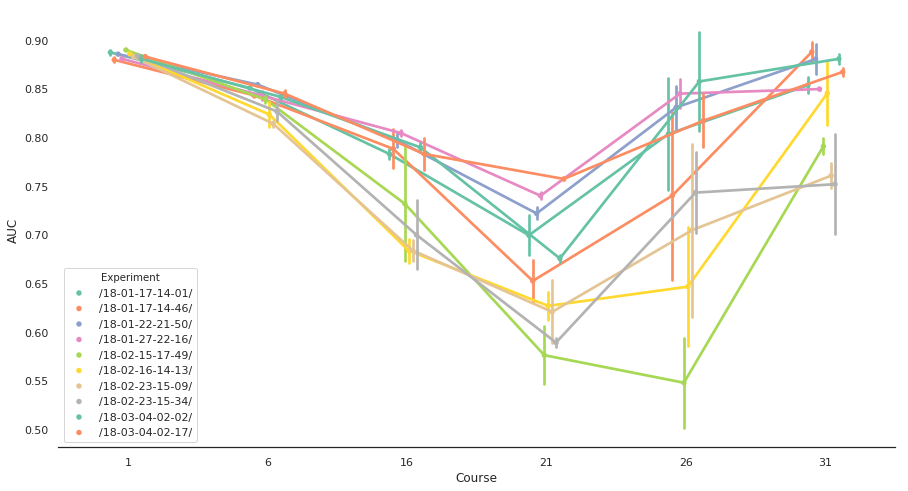

In [20]:
plt.subplots(figsize=(15,8))
exploring_elstm_metrics = embedding_metrics.reset_index()
exploring_elstm_metrics = exploring_elstm_metrics[exploring_elstm_metrics.Course.isin(ANCHOR_COURSES)]
seaborn.pointplot(data=exploring_elstm_metrics, x='Course', y='AUC', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

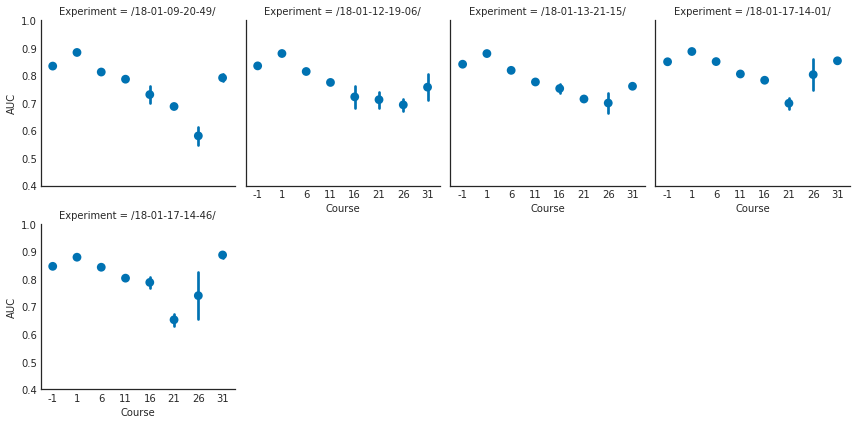

In [55]:
grid = seaborn.FacetGrid(data=embedding_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0.4, 1])
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

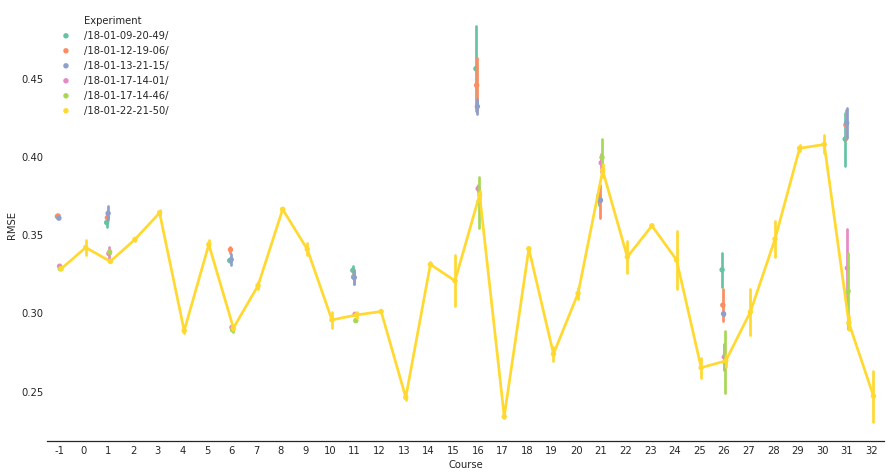

In [82]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=embedding_metrics.reset_index(), x='Course', y='RMSE', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

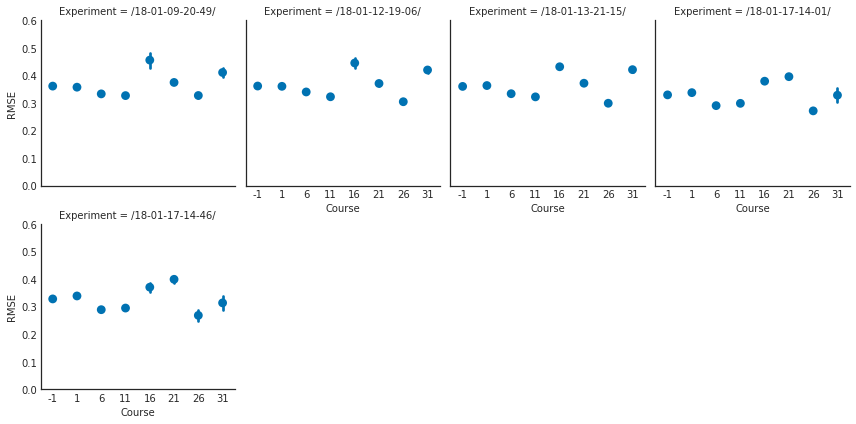

In [57]:
grid = seaborn.FacetGrid(data=embedding_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0, 0.6])
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

## Experiments with CO-Embedde LSTM model

In [17]:
COEMBEDDING_EXPERIMENTS_DIRS = [
    #'/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-09/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-57/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-20-56/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-13/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-22/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-03-12-22/',  # Truncated
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-04-09-45/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-05-17-37/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-09-18-19/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-09-18-46/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-09-20-18/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-10-14-18/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-10-23-03/',
# # #     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-11-16-32/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-12-09-49/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-12-10-31/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-13-20-35/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-28-10-59/',  # Full eval filtered
    # No filtered
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-17-15-29/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-17-16-25/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-22-18-06/',  # Full eval
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-22-18-57/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-26-09-41/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-26-20-05/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-22-18-06/',  # Full eval
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-28-18-51/',  # Full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-28-20-07/',  # Full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-29-00-26/',  # Full eval
#     After AIED
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-02-16-15-08/',  # Full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-02-23-17-43/',  ## Bad LR
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-02-23-16-38/',  ## Bad LR
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-02-27-16-22/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-02-28-09-20/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-02-28-09-20/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-02-28-11-26/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-03-03-02-09/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-03-02-22-25/',  # full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-03-04-01-14/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-03-04-01-26/',  # full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/19-06-06-04-11',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/19-06-06-03-33',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/19-06-06-04-21',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/19-06-06-04-43',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/19-06-06-07-00',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/19-06-07-03-20', # sigmoid
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/19-06-07-03-40', # full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/19-06-07-08-13', # full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/19-06-07-09-04', # full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/19-06-08-04-07', # full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/19-06-08-04-34', # full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/19-06-08-05-12', # full eval
]

## Learning curves

In [56]:
coembedding_performances = read_performances(COEMBEDDING_EXPERIMENTS_DIRS)

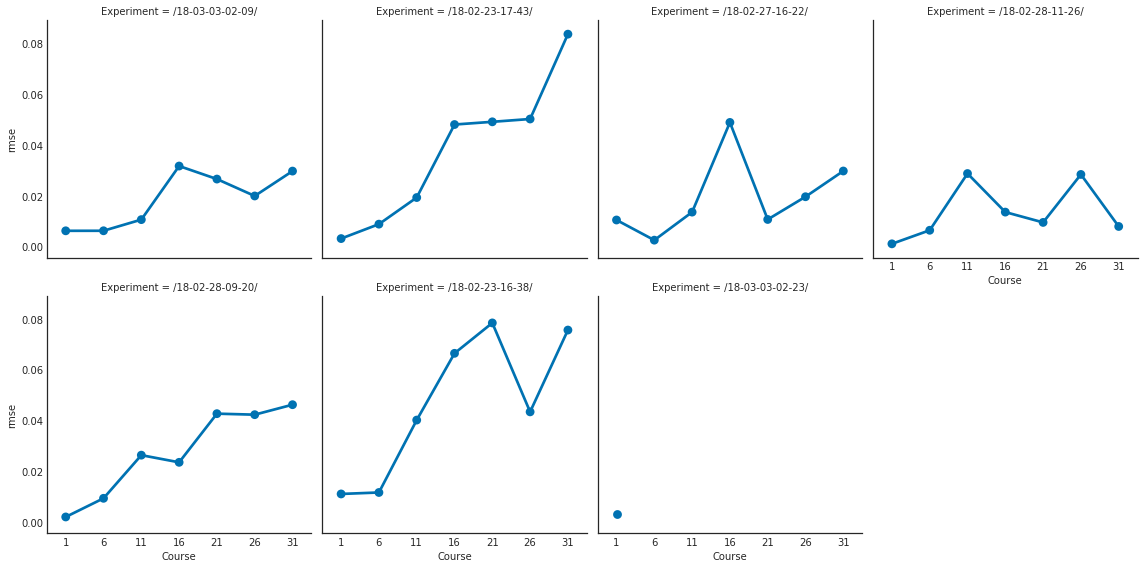

In [12]:
graphic_performances(coembedding_performances)

## Performance Metrics

In [24]:
coembedding_metrics = read_metrics(COEMBEDDING_EXPERIMENTS_DIRS)
coembedding_metrics[:3]

AUC  Accuracy  PositiveRecall Pretrained  \
Experiment       Run Course                                                  
/18-01-17-15-29/ 0   11      0.799524  0.883139        0.984526      False   
                     1       0.884301  0.824697        0.833681      False   
                     26      0.682101  0.905594        0.992248      False   

                                   R2      RMSE  Support  
Experiment       Run Course                               
/18-01-17-15-29/ 0   11      0.246786  0.298322      599  
                     1       0.417732  0.351034     2065  
                     26      0.082850  0.284605      286

In [27]:
co_mean = coembedding_metrics.groupby(['Experiment', 'Course']).aggregate('mean')[METRICS_COLS].reset_index()
co_mean[co_mean.Course.isin(ANCHOR_COURSES[:-2])][-60:]

,Experiment,Course,AUC,RMSE,Accuracy,R2
330,/18-03-04-01-14/,6,0.844301,0.287173,0.899490,0.380624
331,/18-03-04-01-14/,11,0.785088,0.306608,0.879800,0.204262
332,/18-03-04-01-14/,16,0.769911,0.374028,0.819005,0.206446
333,/18-03-04-01-14/,21,0.733320,0.375683,0.820413,0.035858
338,/18-03-04-01-26/,1,0.888085,0.335942,0.852542,0.466721
343,/18-03-04-01-26/,6,0.852160,0.291619,0.893878,0.361110
348,/18-03-04-01-26/,11,0.792176,0.304312,0.881469,0.216205
353,/18-03-04-01-26/,16,0.769606,0.378513,0.805430,0.187298
358,/18-03-04-01-26/,21,0.701349,0.394645,0.801034,-0.063069
377,s/19-06-06-03-33,1,0.886235,0.339739,0.849395,0.454600


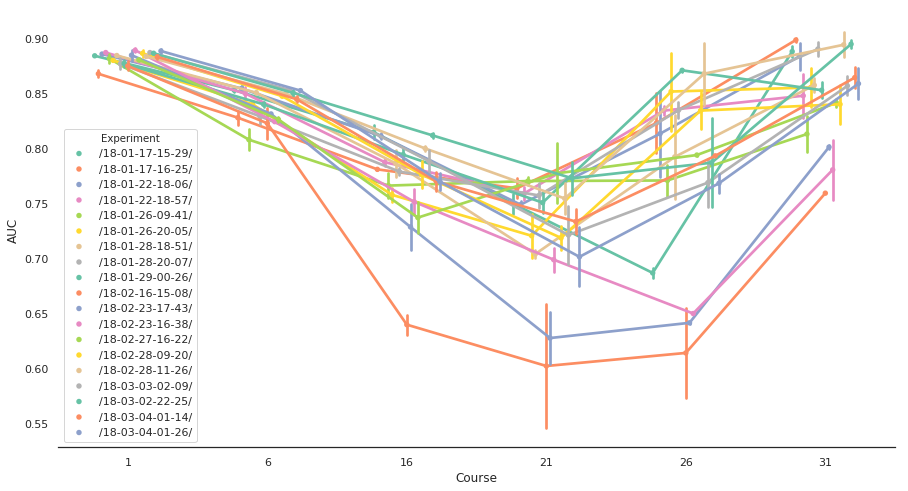

In [24]:
plt.subplots(figsize=(15,8))
exploring_colstm_metrics = coembedding_metrics.reset_index()
exploring_colstm_metrics = exploring_colstm_metrics[exploring_colstm_metrics.Course.isin(ANCHOR_COURSES)]
seaborn.pointplot(data=exploring_colstm_metrics, x='Course', y='AUC', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

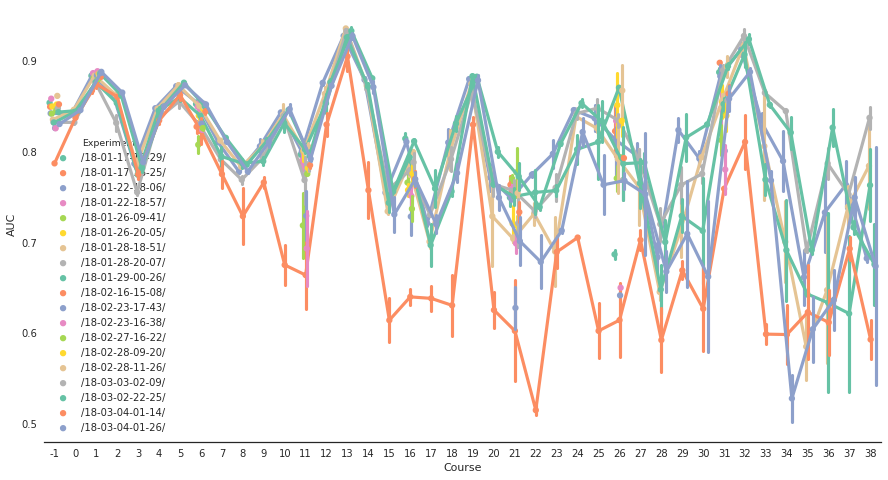

In [30]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=coembedding_metrics.reset_index(), x='Course', y='AUC', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

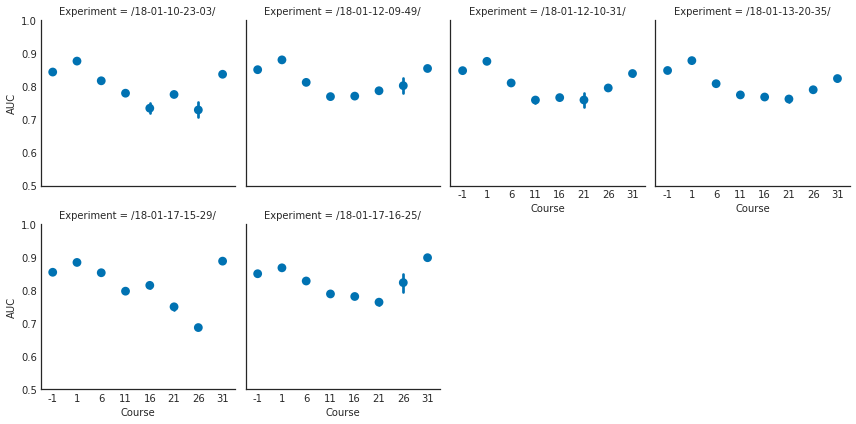

In [76]:
grid = seaborn.FacetGrid(data=coembedding_metrics.reset_index(), col='Experiment', ylim=[0.5, 1], col_wrap=4)
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

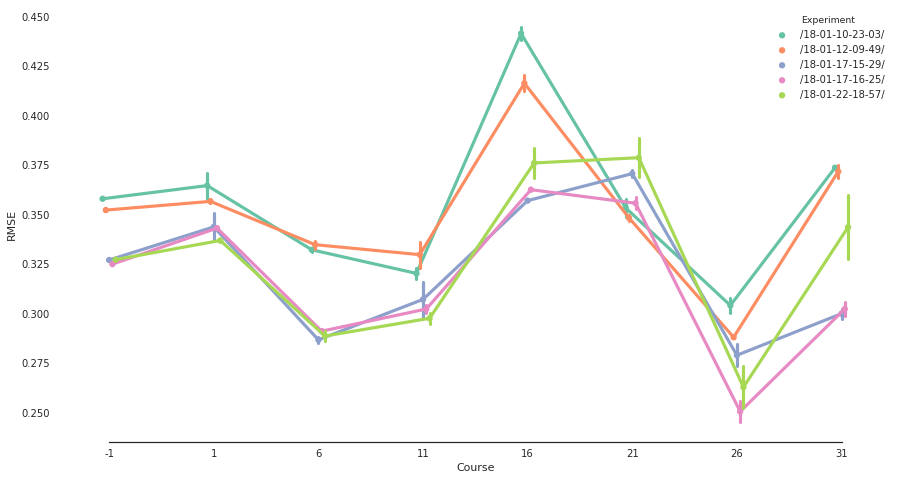

In [158]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=coembedding_metrics.reset_index(), x='Course', y='RMSE', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True, trim=True)

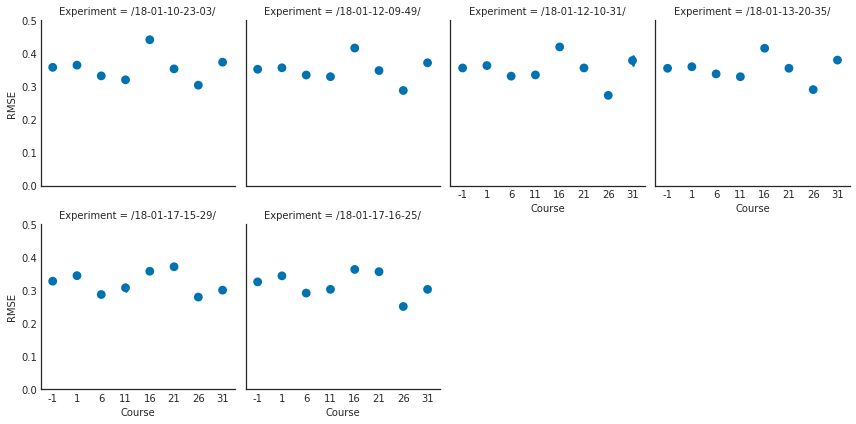

In [78]:
grid = seaborn.FacetGrid(data=coembedding_metrics.reset_index(), col='Experiment', ylim=[0, 0.5], col_wrap=4)
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

# General evaluation

In [29]:
def get_best_metrics(all_metrics_df, DIRNAMES):
    best_performances = all_metrics_df.reset_index().set_index(
        ['Experiment', 'Run']).groupby('Course')['AUC'].apply(numpy.argmax)

    predictions_files = []
    best_metrics = []
    for (course, (experiment, run)) in best_performances.items():
        if course < 0:
            continue
        best_metrics.append((experiment, run, course))
        for dirname in DIRNAMES:
            if experiment in dirname:
                for filename in get_runs(dirname):
                    if '_c{}_'.format(course) in filename and 'run{}.p'.format(run) in filename:
                        predictions_files.append(os.path.join(dirname, filename))

    raw_data = [read_predictions(filename) for filename in predictions_files]
    raw_data = [x for x in zip(*raw_data)]

    true = numpy.concatenate(raw_data[0])
    predicted = numpy.concatenate(raw_data[1])

    return read_file_metrics(true, predicted), all_metrics_df.loc[best_metrics]    

In [30]:
co_general_metrics, co_best_metrics = get_best_metrics(coembedding_metrics, COEMBEDDING_EXPERIMENTS_DIRS)
co_general_metrics

,AUC,RMSE,Accuracy,R2,PositiveRecall,Support
0,0.854582,0.32315,0.864016,0.369552,0.950442,24047


In [31]:
co_best_metrics[:5]

,,,AUC,Accuracy,PositiveRecall,Pretrained,R2,RMSE,Support
Experiment,Run,Course,,,,,,,
s/19-06-07-03-40,0,0,0.853530,0.850479,0.932976,False,0.347617,0.336342,2401
/18-02-23-16-38/,1,1,0.890663,0.853753,0.913013,False,0.468345,0.335431,2065
s/19-06-07-03-40,0,2,0.866043,0.845498,0.943367,False,0.436723,0.348106,1877
/18-01-28-18-51/,0,3,0.793363,0.826748,0.951962,False,0.280321,0.362687,1645
/18-03-04-01-26/,1,4,0.852009,0.899035,0.965997,False,0.406192,0.287992,1555


In [32]:
def add_course_category(metrics_df):
    metrics_df.loc[:, 'course_size'] = pandas.cut(metrics_df.Support, bins=[50, 500, 1500, 3000],
                                                   labels=['Small', 'Medium', 'Big'])
    return metrics_df

In [33]:
co_best_metrics = add_course_category(co_best_metrics)
co_best_metrics.reset_index()[['AUC', 'R2', 'RMSE', 'Accuracy', 'course_size']].groupby('course_size').agg('mean')

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)
/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-v

,AUC,R2,RMSE,Accuracy
course_size,,,,
Small,0.842010,0.237032,0.307653,0.874451
Medium,0.849909,0.351724,0.311377,0.871554
Big,0.851122,0.387840,0.334112,0.855103


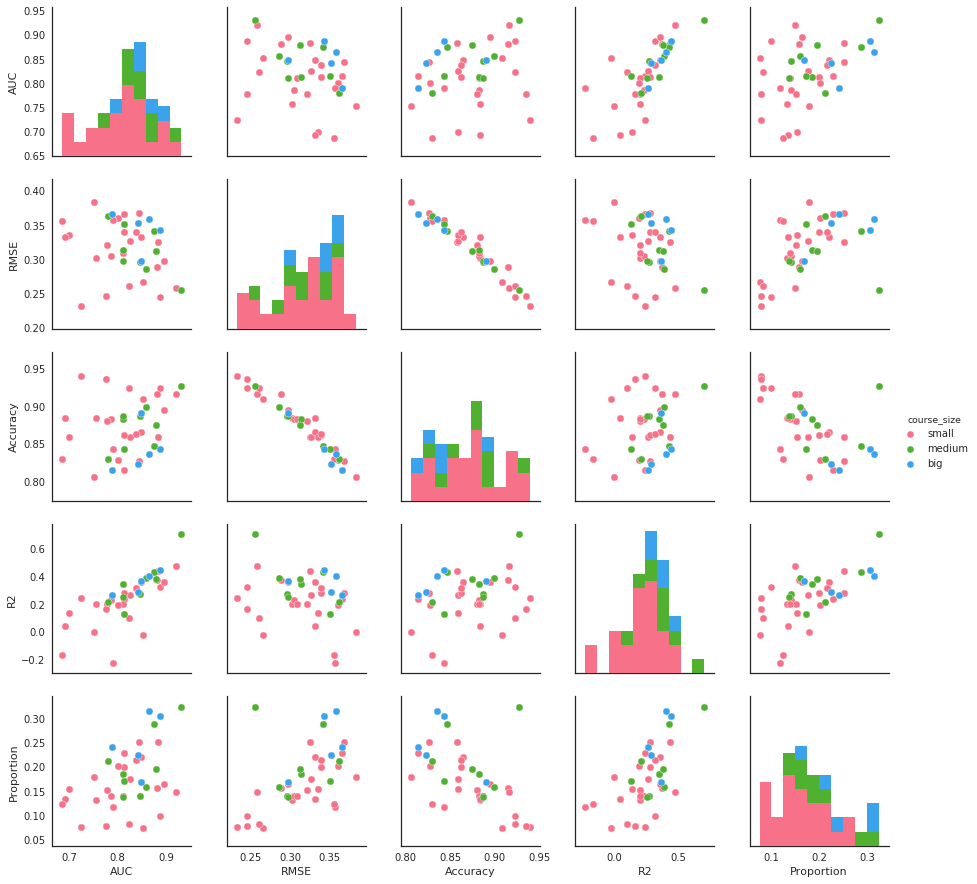

In [32]:
seaborn.pairplot(
    co_best_metrics.reset_index().merge(
        dropout_proportions.drop(labels=1, level='Dropout').reset_index()[['Course', 'Proportion']],
        on='Course')[METRICS_COLS + ['Proportion', 'course_size']],
    hue='course_size', palette="husl"
)

---

In [34]:
em_general_metrics, em_best_metrics = get_best_metrics(embedding_metrics, EMBEDDING_EXPERIMENTS_DIRS)
em_general_metrics

,AUC,RMSE,Accuracy,R2,PositiveRecall,Support
0,0.842786,0.326623,0.864285,0.355636,0.945522,24124


In [35]:
em_best_metrics = add_course_category(em_best_metrics)
em_best_metrics.reset_index()[['AUC', 'R2', 'RMSE', 'Accuracy', 'course_size']].groupby('course_size').agg('mean')

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


,AUC,R2,RMSE,Accuracy
course_size,,,,
Small,0.795480,0.171020,0.319325,0.872610
Medium,0.846182,0.357747,0.309525,0.875380
Big,0.849510,0.379699,0.336103,0.853819


In [36]:
em_best_metrics

AUC  Accuracy  PositiveRecall Pretrained  \
Experiment       Run Course                                                  
/18-01-22-21-50/ 1   0       0.851225  0.841316        0.897051      False   
/18-02-15-17-49/ 1   1       0.889866  0.857143        0.913709       True   
/18-01-22-21-50/ 1   2       0.865212  0.845498        0.951901      False   
                 0   3       0.790714  0.826748        0.962370      False   
                     4       0.850535  0.898392        0.959815      False   
s/19-06-06-08-25 1   5       0.876308  0.846350        0.947619       True   
/18-01-22-21-50/ 0   6       0.854608  0.900000        0.952727      False   
                 1   7       0.809207  0.876201        0.990838      False   
                     8       0.786680  0.813225        0.900000      False   
                     9       0.813402  0.839152        0.914286      False   
                 0   10      0.845123  0.891847        0.984526      False   
s/19-06-06-08-25 1   11      0.818606  0.884808        0.969052       True   
/18-01-22-21-50/ 1   12      0.875116  0.891122        0.954262      False   
                 0   13      0.936588  0.935714        0.981530      False   
                 1   14      0.883763  0.849687        0.944290      False   
                 0   15      0.732551  0.892070        0.969543      False   
/18-01-17-14-46/ 1   16      0.808049  0.832579        0.944282       True   
/18-01-22-21-50/ 0   17      0.705231  0.939675        0.987437      False   
/18-01-27-22-16/ 0   18      0.786668  0.856448        0.943953       True   
/18-01-22-21-50/ 1   19      0.885635  0.905473        0.949853      False   
                 0   20      0.787215  0.885287        0.965217      False   
/18-03-04-02-17/ 1   21      0.758454  0.816537        0.918239       True   
s/19-06-06-08-25 1   22      0.782489  0.867021        0.978056       True   
/18-01-27-22-16/ 1   23      0.783186  0.861953        0.941176       True   
/18-01-22-21-50/ 1   24      0.855245  0.881757        0.956710      False   
s/19-06-06-08-25 0   25      0.819014  0.928814        0.989011       True   
/18-03-04-02-02/ 0   26      0.907877  0.919580        0.957364      False   
/18-01-22-21-50/ 1   27      0.829996  0.875445        0.929752      False   
s/19-06-06-08-25 1   28      0.669173  0.862903        0.980952       True   
/18-01-27-22-16/ 0   29      0.763956  0.846154        0.938144       True   
                     30      0.781469  0.794118        0.915789       True   
s/19-06-06-08-25 0   31      0.897951  0.857143        0.879397       True   
/18-01-27-22-16/ 0   32      0.913720  0.932489        0.970297       True   
/18-01-28-23-57/ 1   33      0.804302  0.807692        0.948718      False   
/18-01-27-22-16/ 0   34      0.794344  0.938462        0.983240       True   
                 1   35      0.700454  0.872222        0.980769       True   
                     36      0.757042  0.928571        0.985915       True   
/18-01-28-23-57/ 1   37      0.762963  0.810458        0.881481      False   
/18-01-27-22-16/ 1   38      0.716261  0.852713        0.929204       True   

                                   R2      RMSE  Support course_size  
Experiment       Run Course                                           
/18-01-22-21-50/ 1   0       0.309064  0.346137     2401         Big  
/18-02-15-17-49/ 1   1       0.473579  0.333776     2065         Big  
/18-01-22-21-50/ 1   2       0.437755  0.347787     1877         Big  
                 0   3       0.269135  0.365495     1645         Big  
                     4       0.408959  0.287320     1555         Big  
s/19-06-06-08-25 1   5       0.431253  0.341124     1178      Medium  
/18-01-22-21-50/ 0   6       0.372627  0.289021      980      Medium  
                 1   7       0.321319  0.319641      937      Medium  
                     8       0.195134  0.366138      862      Medium  
                     9       0.163280  0.344260      8

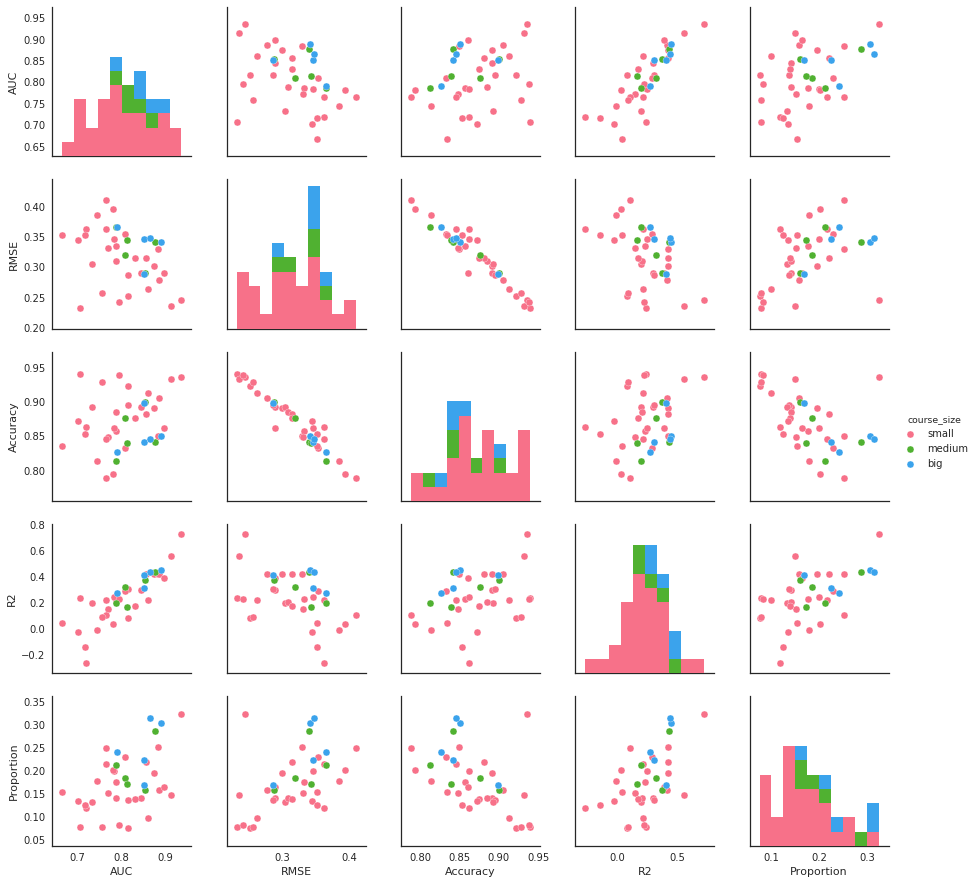

In [112]:
seaborn.pairplot(
    em_best_metrics.reset_index().merge(
        dropout_proportions.drop(labels=1, level='Dropout').reset_index()[['Course', 'Proportion']],
        on='Course')[METRICS_COLS + ['Proportion', 'course_size']],
    hue='course_size', palette="husl"
)

---

In [37]:
lstm_general_metrics, lstm_best_metrics = get_best_metrics(lstm_metrics, LSTM_EXPERIMENTS_DIRS)
lstm_general_metrics

,AUC,RMSE,Accuracy,R2,PositiveRecall,Support
0,0.830983,0.332685,0.860595,0.331492,0.941747,24124


In [38]:
lstm_best_metrics = add_course_category(lstm_best_metrics)
lstm_best_metrics.reset_index()[['AUC', 'R2', 'RMSE', 'Accuracy', 'course_size']].groupby('course_size').agg('mean')

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


,AUC,R2,RMSE,Accuracy
course_size,,,,
Small,0.767687,0.110950,0.331859,0.863681
Medium,0.837138,0.335178,0.314997,0.871245
Big,0.843359,0.380040,0.336407,0.855074


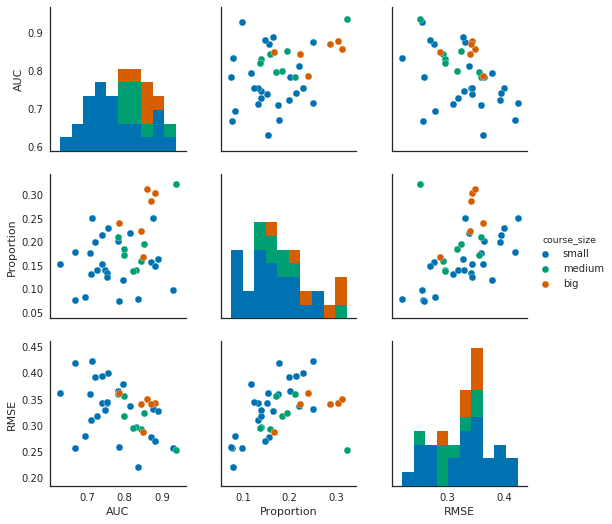

In [136]:
seaborn.pairplot(
`    lstm_best_metrics.reset_index().merge(
        dropout_proportions.drop(labels=1, level='Dropout').reset_index()[['Course', 'Proportion']],
        on='Course')[['AUC', 'Proportion', 'course_size', 'RMSE']],
    hue='course_size', palette="colorblind"
)

----

# Best metrics analysis

In [39]:
best_metrics = pandas.concat(
        [lstm_best_metrics.reset_index(), em_best_metrics.reset_index(),
         co_best_metrics.reset_index()])
best_metrics['Experiment'] = best_metrics.Experiment.apply(lambda x: x.replace('/', '').replace('s', ''))

In [40]:
lstm_best_metrics.loc[:,'Model'] = 'LSTM'
em_best_metrics.loc[:,'Model'] = 'E-LSTM'
co_best_metrics.loc[:,'Model'] = 'Co-ELSTM'

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [41]:
model_pal = {'Co-ELSTM': colors.dark_green}
model_pal['LSTM'] = colors.red
model_pal['E-LSTM'] = colors.dark_blue

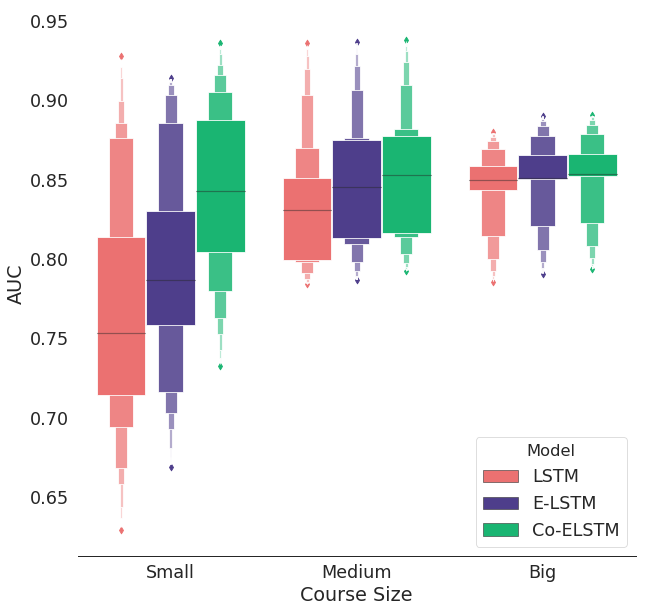

In [42]:
seaborn.set_context("paper", font_scale=2)
plt.subplots(figsize=(10,10))
seaborn.boxenplot(data=pandas.concat(
        [lstm_best_metrics.reset_index(), em_best_metrics.reset_index(),
         co_best_metrics.reset_index()]),
    x='course_size', y='AUC', hue='Model', palette=model_pal)
plt.xlabel('Course Size')
seaborn.despine(left=True)

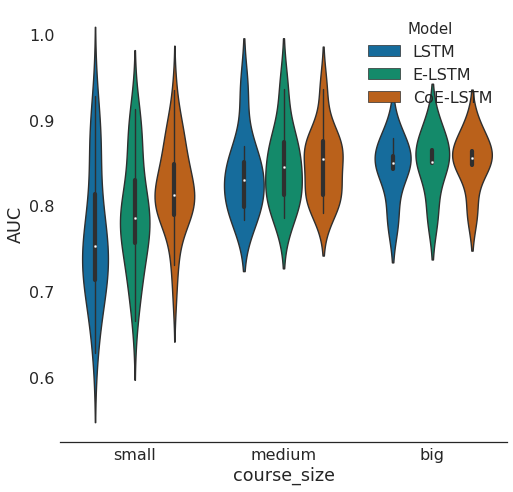

In [54]:
seaborn.set_context("paper", font_scale=2)
plt.subplots(figsize=(8,8))
seaborn.violinplot(data=pandas.concat(
        [lstm_best_metrics.reset_index(), em_best_metrics.reset_index(),
         co_best_metrics.reset_index()]),
    x='course_size', y='AUC', hue='Model', palette='colorblind')
seaborn.despine(left=True)

In [43]:
dropout_metrics = pandas.concat(
        [lstm_best_metrics.reset_index(), em_best_metrics.reset_index(),
         co_best_metrics.reset_index()]).merge(
        dropout_proportions.drop(labels=1, level='Dropout').reset_index()[['Course', 'Proportion']],
        on='Course')

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


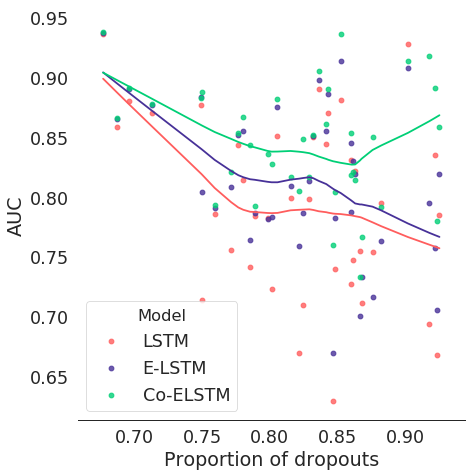

In [44]:
seaborn.lmplot(data=dropout_metrics,
               x='Proportion', y='AUC', hue='Model', palette=model_pal, legend_out=False, size=7,
               lowess=True, truncate=False)
plt.xlabel('Proportion of dropouts')
seaborn.despine(left=True)

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


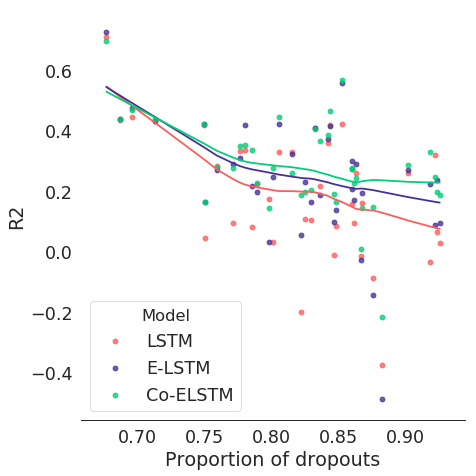

In [45]:
seaborn.lmplot(data=dropout_metrics,
    x='Proportion', y='R2', hue='Model', palette=model_pal, legend_out=False, size=7,
    lowess=True, truncate=False)
plt.xlabel('Proportion of dropouts')
seaborn.despine(left=True)

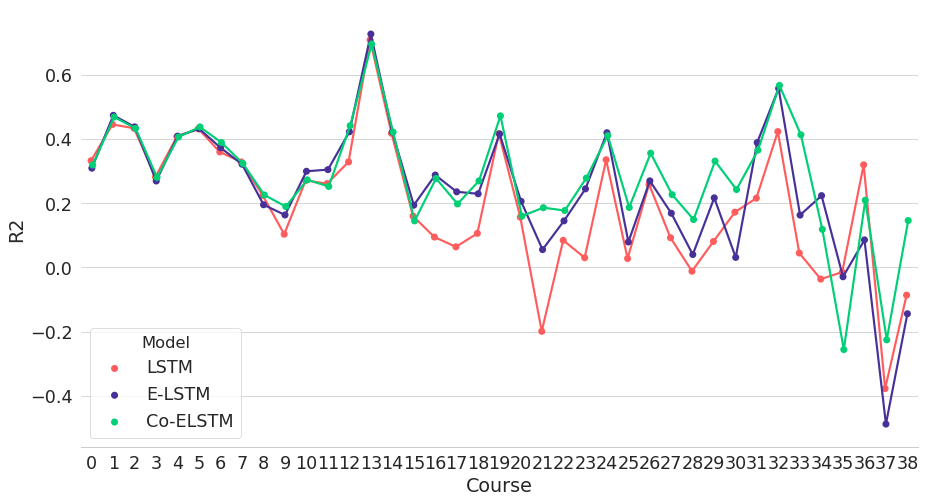

In [80]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=pandas.concat(
        [lstm_best_metrics.reset_index(), em_best_metrics.reset_index(),
         co_best_metrics.reset_index()]), x='Course', y='R2', hue='Model', dodge=True, palette=model_pal)
seaborn.despine(left=True)

----

# Performance distribution

In [46]:
coembedding_metrics.loc[:,'Model'] = 'Co-ELSTM'
embedding_metrics.loc[:,'Model'] = 'E-LSTM'
lstm_metrics.loc[:,'Model'] = 'LSTM'
classifier_distribution = pandas.concat([coembedding_metrics, embedding_metrics, lstm_metrics])
classifier_distribution = classifier_distribution.reset_index()
classifier_distribution['Experiment'] = classifier_distribution['Experiment'].apply(
    lambda x: x.replace('/', '').replace('s', ''))
classifier_distribution = add_course_category(classifier_distribution)
classifier_distribution[classifier_distribution.Course.isin(ANCHOR_COURSES)]

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


,Experiment,Run,Course,AUC,Accuracy,PositiveRecall,Pretrained,R2,RMSE,Support,Model,course_size
0,18-01-17-15-29,0,11,0.799524,0.883139,0.984526,False,0.246786,0.298322,599,Co-ELSTM,Medium
1,18-01-17-15-29,0,1,0.884301,0.824697,0.833681,False,0.417732,0.351034,2065,Co-ELSTM,Big
2,18-01-17-15-29,0,26,0.682101,0.905594,0.992248,False,0.082850,0.284605,286,Co-ELSTM,Small
3,18-01-17-15-29,1,26,0.691376,0.919580,0.996124,False,0.154549,0.273254,286,Co-ELSTM,Small
4,18-01-17-15-29,1,1,0.883202,0.853269,0.946416,False,0.464833,0.336537,2065,Co-ELSTM,Big
5,18-01-17-15-29,1,11,0.794075,0.859766,0.909091,False,0.154911,0.315992,599,Co-ELSTM,Medium
6,18-01-17-15-29,0,31,0.892282,0.873950,0.924623,False,0.354624,0.297364,238,Co-ELSTM,Small
7,18-01-17-15-29,1,31,0.883005,0.861345,0.909548,False,0.332014,0.302528,238,Co-ELSTM,Small
8,18-01-17-15-29,1,16,0.820998,0.830317,0.953079,False,0.277115,0.356985,442,Co-ELSTM,Small
9,18-01-17-15-29,1,21,0.758728,0.816537,0.918239,False,0.071554,0.368812,387,Co-ELSTM,Small


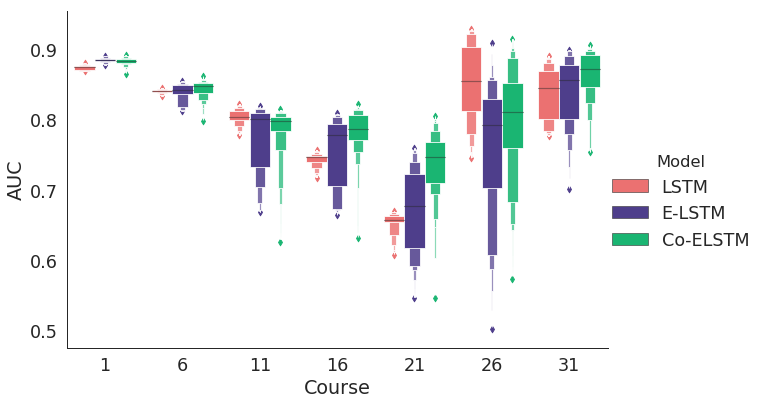

In [47]:
seaborn.catplot(data=classifier_distribution[classifier_distribution.Course.isin(ANCHOR_COURSES)],
                x='Course', y='AUC',
                hue='Model', palette=model_pal, hue_order=['LSTM', 'E-LSTM', 'Co-ELSTM'],
                dodge=True,
                height=6, aspect=1.5,
                kind='boxen'
               )

In [104]:
add_course_category(classifier_distribution)[classifier_distribution.Course.isin(ANCHOR_COURSES)]

,Experiment,Run,Course,AUC,Accuracy,PositiveRecall,Pretrained,R2,RMSE,Support,Model,course_size
1,18-01-17-15-29,0,1,0.884301,0.824697,0.833681,False,0.417732,0.351034,2065,Co-ELSTM,Big
2,18-01-17-15-29,0,26,0.682101,0.905594,0.992248,False,0.082850,0.284605,286,Co-ELSTM,Small
3,18-01-17-15-29,1,26,0.691376,0.919580,0.996124,False,0.154549,0.273254,286,Co-ELSTM,Small
4,18-01-17-15-29,1,1,0.883202,0.853269,0.946416,False,0.464833,0.336537,2065,Co-ELSTM,Big
6,18-01-17-15-29,0,31,0.892282,0.873950,0.924623,False,0.354624,0.297364,238,Co-ELSTM,Small
7,18-01-17-15-29,1,31,0.883005,0.861345,0.909548,False,0.332014,0.302528,238,Co-ELSTM,Small
8,18-01-17-15-29,1,16,0.820998,0.830317,0.953079,False,0.277115,0.356985,442,Co-ELSTM,Small
9,18-01-17-15-29,1,21,0.758728,0.816537,0.918239,False,0.071554,0.368812,387,Co-ELSTM,Small
10,18-01-17-15-29,1,6,0.850870,0.893878,0.961212,False,0.376452,0.288139,980,Co-ELSTM,Medium
11,18-01-17-15-29,0,6,0.854272,0.900000,0.960000,False,0.388473,0.285348,980,Co-ELSTM,Medium


# Hyperparameter analysis

In [48]:
hyp = pandas.read_csv('../../results/kddcup/classifier_hyperparameters.tsv', sep='\t')
hyp.Experiment.unique().size

44

In [49]:
hyp = hyp[hyp.LR == 0.001].merge(classifier_distribution.drop('Pretrained', axis=1), on='Experiment')
hyp.Experiment.unique().size

40

In [50]:
hyp[:3]

,Experiment,ModelType,Distance,LR,BatchSize,Dropout,EmbeddingSize,LSTMUnits,MaxSteps,Pretrained,...,Run,Course,AUC,Accuracy,PositiveRecall,R2,RMSE,Support,Model,course_size
0,18-01-17-13-47,LSTM,NaN,0.001,50,0.3,NaN,50,50,No,...,1,31,0.787785,0.836134,0.879397,-0.008099,0.371649,238,LSTM,Small
1,18-01-17-13-47,LSTM,NaN,0.001,50,0.3,NaN,50,50,No,...,0,6,0.843785,0.892857,0.943030,0.359565,0.292014,980,LSTM,Medium
2,18-01-17-13-47,LSTM,NaN,0.001,50,0.3,NaN,50,50,No,...,1,6,0.839726,0.897959,0.964848,0.378429,0.287682,980,LSTM,Medium


In [51]:
classifier_distribution.Experiment.unique().size

46

## Hyperparameter distribution

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


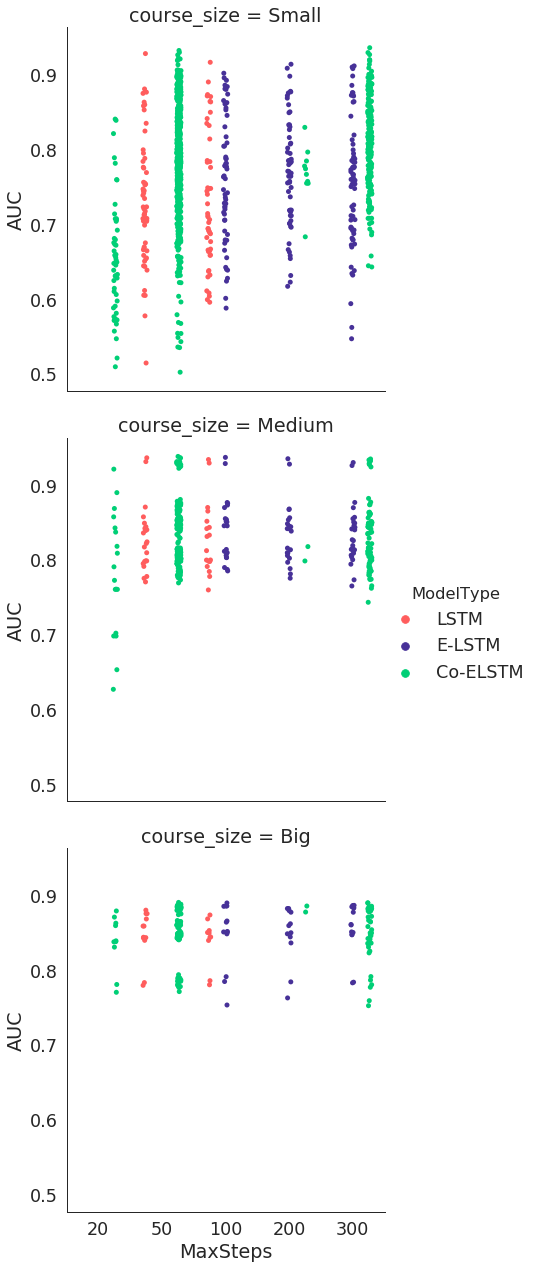

In [52]:
seaborn.catplot(data=hyp, row='course_size', y='AUC', x='MaxSteps', #col='ModelType',
                # hue='Course',
                hue='ModelType', palette=model_pal,
                dodge=True,
                size=6, aspect=1)

## Pretrained impact

In [53]:
best_hyp = hyp[['Experiment', 'ModelType', 'Course', 'course_size', 'AUC']].groupby(
    ['Experiment', 'ModelType', 'Course']).agg('mean')

In [54]:
hyp[:3]

,Experiment,ModelType,Distance,LR,BatchSize,Dropout,EmbeddingSize,LSTMUnits,MaxSteps,Pretrained,...,Run,Course,AUC,Accuracy,PositiveRecall,R2,RMSE,Support,Model,course_size
0,18-01-17-13-47,LSTM,NaN,0.001,50,0.3,NaN,50,50,No,...,1,31,0.787785,0.836134,0.879397,-0.008099,0.371649,238,LSTM,Small
1,18-01-17-13-47,LSTM,NaN,0.001,50,0.3,NaN,50,50,No,...,0,6,0.843785,0.892857,0.943030,0.359565,0.292014,980,LSTM,Medium
2,18-01-17-13-47,LSTM,NaN,0.001,50,0.3,NaN,50,50,No,...,1,6,0.839726,0.897959,0.964848,0.378429,0.287682,980,LSTM,Medium


In [55]:
def create_ce_column(x):
    if x[0] == 'Yes':  # Pretrained
        if x[1] == 'Yes':  # Finetuned
            return 'Pretrained+Finetuned'
        return 'Pretrained'
    return 'Random'

In [56]:
keys = ['ModelType', 'Pretrained', 'Finetuned', 'Course']
metrics = ['AUC', 'Support']
mean_by_run = hyp[['Experiment'] + keys + metrics].groupby(['Experiment'] + keys).agg('mean').reset_index()
hyp_by_pretrained = add_course_category(mean_by_run.groupby(keys).agg('max').reset_index())
hyp_by_pretrained.loc[:,'CE Embedding'] = hyp_by_pretrained[['Pretrained', 'Finetuned']].fillna('No').apply(
    create_ce_column, axis=1)
hyp_by_pretrained[hyp_by_pretrained.Course == 1]

,ModelType,Pretrained,Finetuned,Course,Experiment,AUC,Support,course_size,CE Embedding
2,Co-ELSTM,No,No,1,19-06-07-03-40,0.888085,2065,Big,Random
42,Co-ELSTM,Yes,No,1,19-06-08-04-07,0.880129,2065,Big,Pretrained
82,Co-ELSTM,Yes,Yes,1,19-06-07-08-13,0.885983,2065,Big,Pretrained+Finetuned
122,E-LSTM,No,No,1,18-03-04-02-02,0.887088,2065,Big,Random
162,E-LSTM,Yes,No,1,18-01-27-22-16,0.880529,2065,Big,Pretrained
202,E-LSTM,Yes,Yes,1,19-06-06-08-25,0.886029,2065,Big,Pretrained+Finetuned
242,LSTM,No,No,1,18-01-27-21-28,0.877407,2065,Big,Random


In [57]:
hue_order_pretrained = ['Random', 'Pretrained', 'Pretrained+Finetuned']
pretrained_pal = {
    hue_order_pretrained[0]: colors.red,
    hue_order_pretrained[1]: colors.dark_green,
    hue_order_pretrained[2]: colors.purple,
}

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


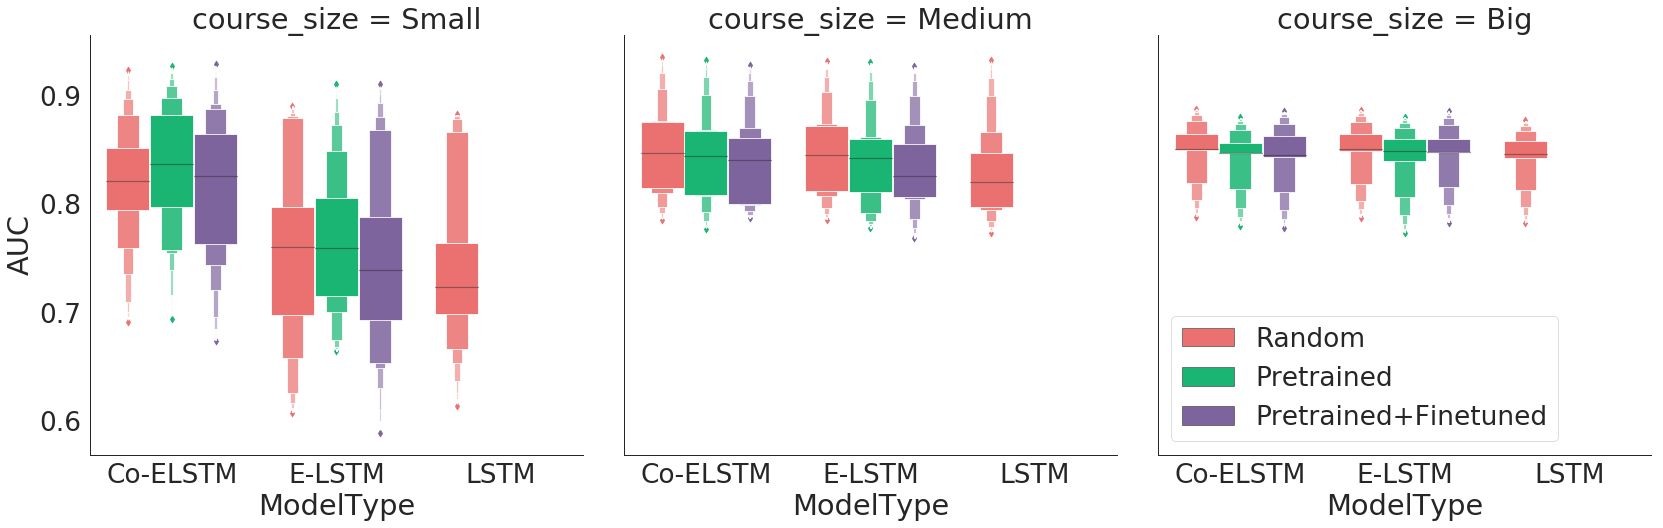

In [58]:
seaborn.set_context("paper", font_scale=3)
seaborn.catplot(data=hyp_by_pretrained, col='course_size', y='AUC', hue='CE Embedding',
                x='ModelType', legend=False,
                dodge=True, palette=pretrained_pal, hue_order=hue_order_pretrained,
                size=8, aspect=1, kind='boxen',)
plt.legend(loc='lower left')

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


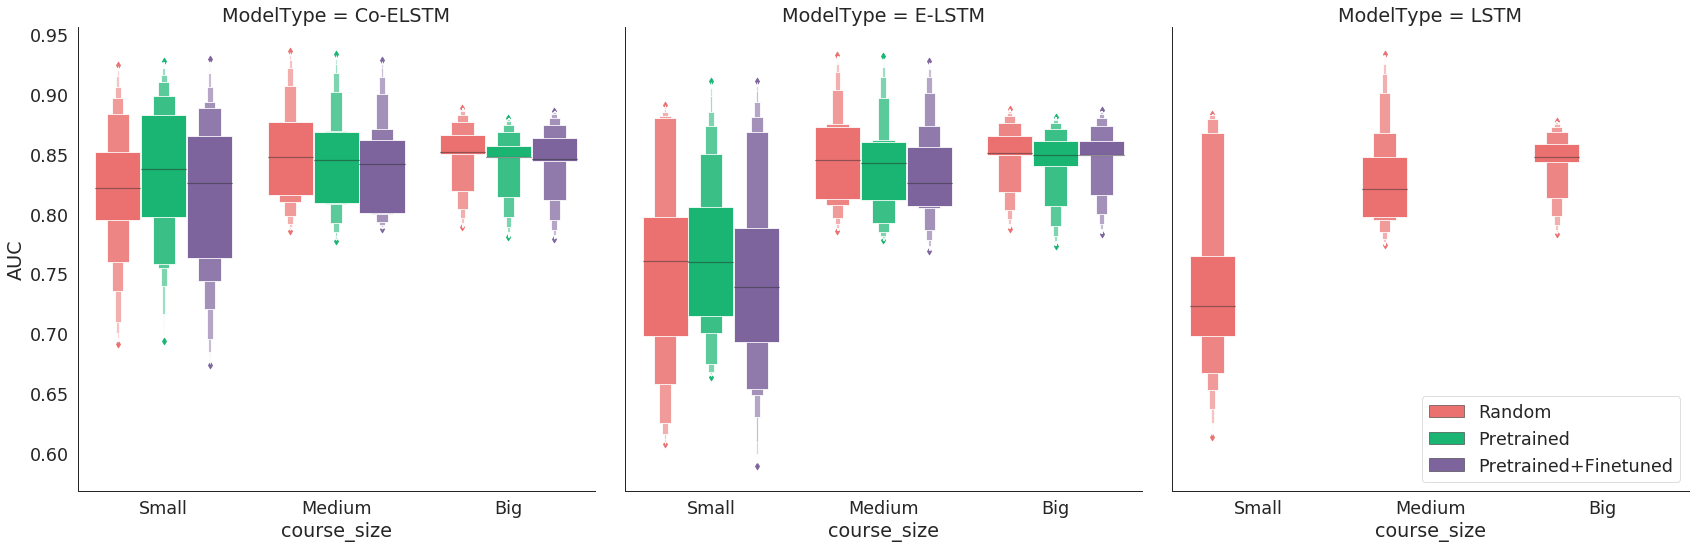

In [59]:
seaborn.set_context("paper", font_scale=2)
seaborn.catplot(data=hyp_by_pretrained, col='ModelType', y='AUC', hue='CE Embedding',
                x='course_size', legend=False,
                dodge=True, palette=pretrained_pal, hue_order=hue_order_pretrained,
                size=8, aspect=1, kind='boxen',)
plt.legend(loc='lower right')

In [283]:
hyp_by_pretrained[:3]

,ModelType,Pretrained,Finetuned,Course,Experiment,AUC,Support,course_size,CE Embedding
0,Co-ELSTM,No,No,-1,18-03-04-01-26,0.861552,48248,NaN,Random
1,Co-ELSTM,No,No,0,18-03-04-01-26,0.846198,2401,Big,Random
2,Co-ELSTM,No,No,1,18-03-04-01-26,0.888085,2065,Big,Random


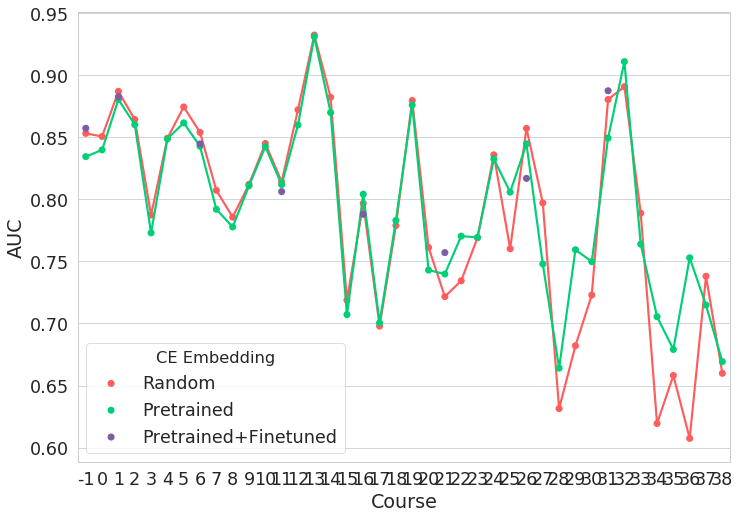

In [289]:
seaborn.pointplot(data=hyp_by_pretrained[hyp_by_pretrained.ModelType == 'E-LSTM'],
                 y='AUC', hue='CE Embedding', x='Course', palette=pretrained_pal)

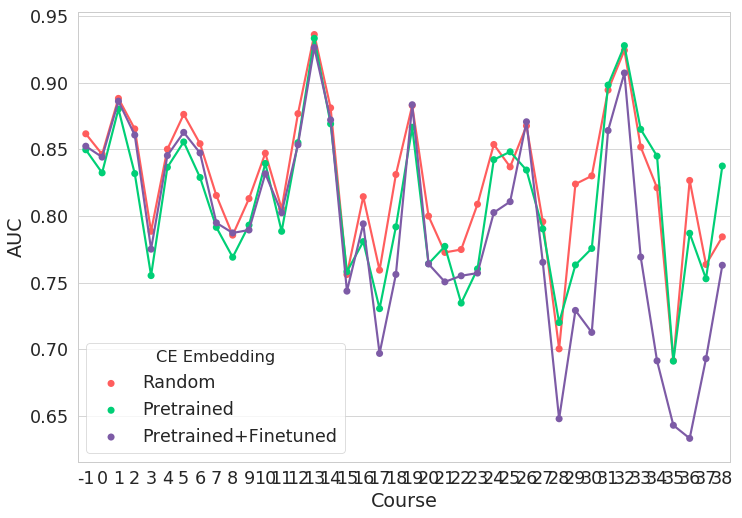

In [290]:
seaborn.pointplot(data=hyp_by_pretrained[hyp_by_pretrained.ModelType == 'Co-ELSTM'],
                 y='AUC', hue='CE Embedding', x='Course', palette=pretrained_pal)

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


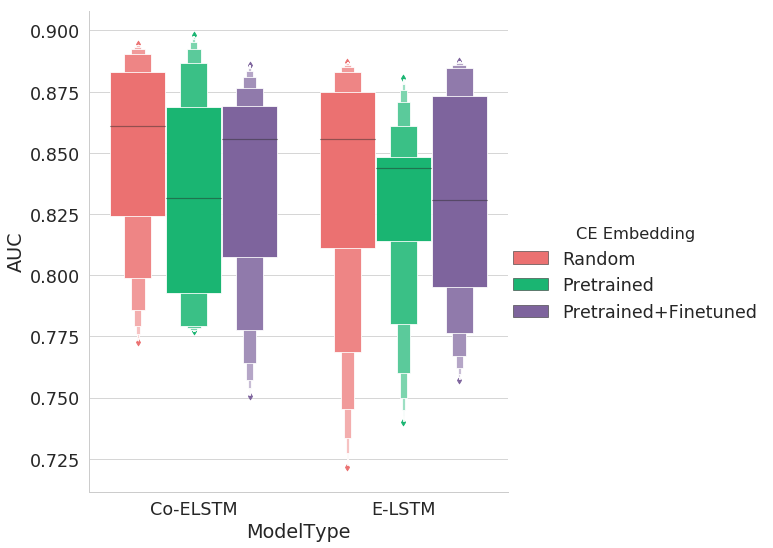

In [291]:
seaborn.set_context("paper", font_scale=2)
seaborn.catplot(data=hyp_by_pretrained[hyp_by_pretrained.Course.isin(ANCHOR_COURSES)], y='AUC', hue='CE Embedding',
                x='ModelType',
                dodge=True, palette=pretrained_pal, hue_order=hue_order_pretrained,
                size=8, aspect=1, kind='boxen',)


## Distance function analysis

In [80]:
hyp[:3]

,Experiment,ModelType,Distance,LR,BatchSize,Dropout,EmbeddingSize,LSTMUnits,MaxSteps,Pretrained,...,Run,Course,AUC,Accuracy,PositiveRecall,R2,RMSE,Support,Model,course_size
0,18-01-17-13-47,LSTM,NaN,0.001,50,0.3,NaN,50,50,No,...,1,31,0.787785,0.836134,0.879397,-0.008099,0.371649,238,LSTM,Small
1,18-01-17-13-47,LSTM,NaN,0.001,50,0.3,NaN,50,50,No,...,0,6,0.843785,0.892857,0.943030,0.359565,0.292014,980,LSTM,Medium
2,18-01-17-13-47,LSTM,NaN,0.001,50,0.3,NaN,50,50,No,...,1,6,0.839726,0.897959,0.964848,0.378429,0.287682,980,LSTM,Medium


/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


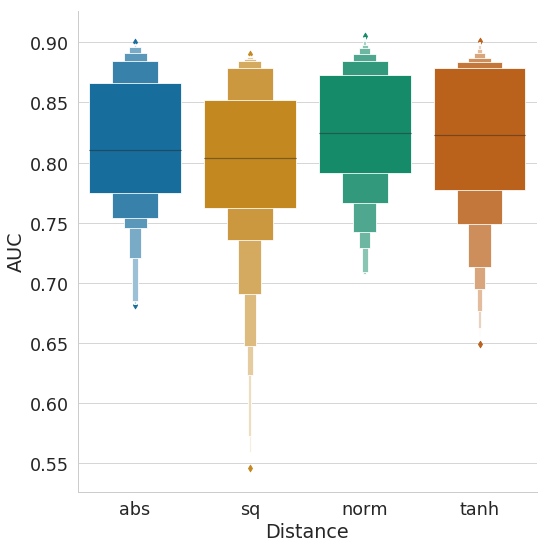

In [89]:
seaborn.catplot(data=hyp[hyp.Course.isin(ANCHOR_COURSES) & (hyp.ModelType == 'Co-ELSTM')],
                y='AUC', x='Distance',
                #hue='Distance',
                dodge=True,
                size=8, aspect=1, kind='boxen',)